In [6]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from epl.query import create_and_query, create_conn, get_table_columns, query_creator, query_db, table_exists
from epl.features_parse import create_col_map

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [9]:
FEATS = {'GF': {'Home': 'FTHG', 'Away': 'FTAG'},
         'GA': {'Home': 'FTAG', 'Away': 'FTHG'},

         'GFH': {'Home': 'FTHG'},
         'GAH': {'Home': 'FTAG'},
         'GFA': {'Away': 'FTAG'},
         'GAA': {'Away': 'FTHG'},

         'SF': {'Home': 'HS', 'Away': 'AS'},
         'SA': {'Home': 'AS', 'Away': 'HS'},

         'SFH': {'Home': 'HS'},
         'SAH': {'Home': 'AS'},
         'SFA': {'Away': 'AS'},
         'SAA': {'Away': 'HS'},

         'STF': {'Home': 'HST', 'Away': 'AST'},
         'STA': {'Home': 'AST', 'Away': 'HST'},

         'STFH': {'Home': 'HST'},
         'STAH': {'Home': 'AST'},
         'STFA': {'Away': 'AST'},
         'STAA': {'Away': 'HST'},

         'PPG': {'Home': 'FTR', 'Away': 'FTR'},
         'PPGH': {'Home': 'FTR'},
         'PPGA': {'Away': 'FTR'},
         }

FEAT_LIST = [{'feat_type': 'avg',
              'feat_dict': FEATS,
              'streak': x,
              'avg_type': 'Avg'} for x in [3, 5, 10, 20, 40]]

In [7]:
df_d = create_and_query('matches', cols=['Date', 'Country', 'Div', 'Season', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR'])

Running query: SELECT Date, Country, Div, Season, HomeTeam, AwayTeam, FTHG, FTAG, FTR FROM matches 


In [10]:
feats = [el for l in [list(create_col_map(FEAT_LIST[0]['feat_dict'], x, 'Avg').keys()) for x in [3,10,20,40]] for el in l]

In [11]:
key_cols = ['Date', 'Team', 'Location']

In [12]:
df_f = create_and_query('features', cols=key_cols + feats)

Running query: SELECT Date, Team, Location, AvgGF_3, AvgGA_3, AvgGFH_3, AvgGAH_3, AvgGFA_3, AvgGAA_3, AvgSF_3, AvgSA_3, AvgSFH_3, AvgSAH_3, AvgSFA_3, AvgSAA_3, AvgSTF_3, AvgSTA_3, AvgSTFH_3, AvgSTAH_3, AvgSTFA_3, AvgSTAA_3, AvgPPG_3, AvgPPGH_3, AvgPPGA_3, AvgGF_10, AvgGA_10, AvgGFH_10, AvgGAH_10, AvgGFA_10, AvgGAA_10, AvgSF_10, AvgSA_10, AvgSFH_10, AvgSAH_10, AvgSFA_10, AvgSAA_10, AvgSTF_10, AvgSTA_10, AvgSTFH_10, AvgSTAH_10, AvgSTFA_10, AvgSTAA_10, AvgPPG_10, AvgPPGH_10, AvgPPGA_10, AvgGF_20, AvgGA_20, AvgGFH_20, AvgGAH_20, AvgGFA_20, AvgGAA_20, AvgSF_20, AvgSA_20, AvgSFH_20, AvgSAH_20, AvgSFA_20, AvgSAA_20, AvgSTF_20, AvgSTA_20, AvgSTFH_20, AvgSTAH_20, AvgSTFA_20, AvgSTAA_20, AvgPPG_20, AvgPPGH_20, AvgPPGA_20, AvgGF_40, AvgGA_40, AvgGFH_40, AvgGAH_40, AvgGFA_40, AvgGAA_40, AvgSF_40, AvgSA_40, AvgSFH_40, AvgSAH_40, AvgSFA_40, AvgSAA_40, AvgSTF_40, AvgSTA_40, AvgSTFH_40, AvgSTAH_40, AvgSTFA_40, AvgSTAA_40, AvgPPG_40, AvgPPGH_40, AvgPPGA_40 FROM features 


In [13]:
df_d = df_d[df_d.Season != '9394']
#df_d = df_d[df_d.Div == 'E0']

In [14]:
df = pd.merge(left=df_d, right=df_f, how='left', left_on=['Date', 'HomeTeam'], right_on=['Date', 'Team'])
df = df.rename(columns=dict(zip(feats, ['Home'+x for x in feats])))

df = pd.merge(left=df, right=df_f, how='left', left_on=['Date', 'AwayTeam'], right_on=['Date', 'Team'])
df = df.rename(columns=dict(zip(feats, ['Away'+x for x in feats])))

In [15]:
for col in feats:
    df['Diff'+col] = df['Home'+col] - df['Away'+col]

In [16]:
df_est = df[[x for x in df.columns if 'Diff' in x or x in ['Date', 'Season', 'Div', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]]
df_est = df_est.dropna()
df_est.tail()

,Date,Div,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,DiffAvgGF_3,DiffAvgGA_3,DiffAvgGFH_3,DiffAvgGAH_3,DiffAvgGFA_3,DiffAvgGAA_3,DiffAvgSF_3,DiffAvgSA_3,DiffAvgSFH_3,DiffAvgSAH_3,DiffAvgSFA_3,DiffAvgSAA_3,DiffAvgSTF_3,DiffAvgSTA_3,DiffAvgSTFH_3,DiffAvgSTAH_3,DiffAvgSTFA_3,DiffAvgSTAA_3,DiffAvgPPG_3,DiffAvgPPGH_3,DiffAvgPPGA_3,DiffAvgGF_10,DiffAvgGA_10,DiffAvgGFH_10,DiffAvgGAH_10,DiffAvgGFA_10,DiffAvgGAA_10,DiffAvgSF_10,DiffAvgSA_10,DiffAvgSFH_10,DiffAvgSAH_10,DiffAvgSFA_10,DiffAvgSAA_10,DiffAvgSTF_10,DiffAvgSTA_10,DiffAvgSTFH_10,DiffAvgSTAH_10,DiffAvgSTFA_10,DiffAvgSTAA_10,DiffAvgPPG_10,DiffAvgPPGH_10,DiffAvgPPGA_10,DiffAvgGF_20,DiffAvgGA_20,DiffAvgGFH_20,DiffAvgGAH_20,DiffAvgGFA_20,DiffAvgGAA_20,DiffAvgSF_20,DiffAvgSA_20,DiffAvgSFH_20,DiffAvgSAH_20,DiffAvgSFA_20,DiffAvgSAA_20,DiffAvgSTF_20,DiffAvgSTA_20,DiffAvgSTFH_20,DiffAvgSTAH_20,DiffAvgSTFA_20,DiffAvgSTAA_20,DiffAvgPPG_20,DiffAvgPPGH_20,DiffAvgPPGA_20,DiffAvgGF_40,DiffAvgGA_40,DiffAvgGFH_40,DiffAvgGAH_40,DiffAvgGFA_40,DiffAvgGAA_40,DiffAvgSF_40,DiffAvgSA_40,DiffAvgSFH_40,DiffAvgSAH_40,DiffAvgSFA_40,DiffAvgSAA_40,DiffAvgSTF_40,DiffAvgSTA_40,DiffAvgSTFH_40,DiffAvgSTAH_40,DiffAvgSTFA_40,DiffAvgSTAA_40,DiffAvgPPG_40,DiffAvgPPGH_40,DiffAvgPPGA_40
185510,2020-12-07,D1,2021,Hoffenheim,Augsburg,3.0,1.0,H,1.000000,0.333333,0.000000,0.666667,0.333333,0.000000,3.000000,2.333333,-1.000000,4.666667,5.000000,-6.000000,3.000000,1.333333,1.666667,1.666667,2.333333,-1.666667,0.000000,-1.000000,0.000000,0.7,0.2,0.7,0.8,0.8,0.0,4.2,-1.2,3.1,1.1,4.8,-0.5,2.6,-0.3,2.3,0.9,2.3,-0.4,0.0,0.1,0.4,0.60,0.25,0.00,0.45,0.65,-0.55,3.45,-0.05,3.15,0.25,2.85,0.05,2.05,0.00,1.70,0.60,1.15,-0.45,0.30,0.00,0.65,0.325,0.000,-0.025,-0.100,0.875,-0.575,3.075,-0.050,3.800,-1.125,3.400,-0.250,1.425,0.125,1.100,0.100,1.950,-0.525,0.250,0.300,0.625
185511,2020-12-07,G1,2021,Panetolikos,Larisa,2.0,1.0,H,0.000000,-1.333333,0.333333,-0.333333,-1.000000,-0.666667,-1.333333,-1.666667,-3.333333,0.666667,-3.000000,-2.000000,-1.333333,-0.666667,-2.000000,1.000000,-2.333333,-0.666667,0.000000,0.000000,-1.000000,-0.2,-0.1,0.1,-0.3,0.3,-0.2,-2.9,-0.7,-0.8,1.5,-0.8,-2.0,-1.9,0.3,-0.8,1.3,-0.6,-0.1,-0.3,0.5,0.1,0.10,-0.05,-0.25,-0.05,0.00,0.05,-1.10,-0.20,-1.35,2.15,-0.85,-1.90,-0.95,0.70,-0.90,1.50,-0.20,-0.10,0.10,-0.15,-0.25,-0.150,0.000,-0.025,0.100,0.150,0.400,-1.075,0.200,-2.325,1.750,-0.150,-1.250,-0.550,0.725,-1.025,1.450,0.250,0.000,-0.200,0.000,-0.100
185512,2020-12-07,I1,2021,Fiorentina,Genoa,1.0,1.0,D,-0.666667,-1.000000,0.333333,-0.666667,-0.333333,0.666667,-2.666667,-2.000000,-1.000000,1.333333,-1.000000,-2.333333,-0.333333,-3.000000,-0.666667,1.666667,0.333333,-2.333333,0.333333,1.000000,-0.333333,0.2,-0.2,-0.1,-0.6,0.5,-0.7,2.8,-2.4,3.9,-2.6,1.0,-2.1,1.5,-1.1,1.3,0.3,1.3,-1.8,0.3,0.3,0.2,0.25,-0.70,-0.25,-0.70,0.40,-0.45,2.35,-1.90,3.10,-1.85,0.90,-3.05,1.20,-0.95,0.45,-0.05,1.15,-1.80,0.35,0.20,0.25,0.050,-0.575,-0.050,-0.425,0.400,-0.450,2.050,-2.500,1.625,-1.900,1.425,-2.900,0.850,-0.925,0.075,-0.575,1.650,-1.700,0.175,0.125,0.325
185515,2020-12-07,SP1,2021,Eibar,Valencia,0.0,0.0,D,-1.000000,-1.000000,-2.000000,-0.666667,0.000000,-1.666667,3.000000,-4.666667,3.666667,-8.000000,-5.333333,3.333333,1.000000,-1.000000,1.000000,-2.666667,-0.666667,0.333333,0.333333,-0.666667,2.000000,-0.5,-0.6,-1.1,-0.4,0.4,-0.4,0.9,-4.5,2.0,-6.8,1.2,-1.8,0.3,-1.0,0.3,-2.1,0.9,0.3,0.3,-0.7,1.2,-0.35,-0.40,-0.65,0.15,-0.05,-0.40,1.60,-4.30,2.30,-5.55,1.65,-4.20,0.60,-0.90,0.30,-1.15,0.95,-1.35,0.25,-0.90,0.50,-0.325,-0.125,-0.225,0.275,-0.325,-0.100,2.400,-4.950,1.875,-3.850,1.900,-5.450,0.775,-1.275,0.350,-0.525,0.100,-1.625,-0.150,-0.450,-0.175
185518,2020-12-07,T1,2021,Trabzonspor,Sivasspor,1.0,1.0,D,0.333333,-1.000000,1.000000,0.333333,-0.666667,0.333333,0.000000,3.666667,3.000000,12.333333,-2.333333,0.666667,-1.666667,1.666667,0.000000,5.666667,-1.333333,0.333333,2.000000,1.000000,-0.333333,0.3,0.1,1.4,0.8,0.0,0.1,-2.0,5.0,0.6,5.9,-2.2,3.2,-0.5,1.7,-0.3,2.2,0.1,1.1,0.3,0.4,0.0,0.60,0.40,1.15,0.60,0.05,-0.30,-1.00,3.95,0.80,4.10

In [17]:
# define x and y dataframes - will convert to np.array if required for sklearn (rather than sm)
features = [x for x in df.columns if 'Diff' in x]
features = [x for x in features if any([y in x for y in ['PPG', 'GF', 'GA']])]
y = df_est['FTR']
X = df_est[features]

In [18]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from epl.model_utils import gen_sm_logit_preds, print_conf_mat, print_logit_params, sm_logit_output_explanation

In [19]:
test_frac = 1/10
seed = 123

# split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_frac, random_state=seed, stratify=y)

print('Using {:,} cases for training'.format(x_train.shape[0]))
print('---')
print('Using {:,} cases for testing'.format(x_test.shape[0]))
print('---')
print('Using following factors to predict: {}'.format(', '.join(features)))

Using 49,323 cases for training
---
Using 5,481 cases for testing
---
Using following factors to predict: DiffAvgGF_3, DiffAvgGA_3, DiffAvgGFH_3, DiffAvgGAH_3, DiffAvgGFA_3, DiffAvgGAA_3, DiffAvgPPG_3, DiffAvgPPGH_3, DiffAvgPPGA_3, DiffAvgGF_10, DiffAvgGA_10, DiffAvgGFH_10, DiffAvgGAH_10, DiffAvgGFA_10, DiffAvgGAA_10, DiffAvgPPG_10, DiffAvgPPGH_10, DiffAvgPPGA_10, DiffAvgGF_20, DiffAvgGA_20, DiffAvgGFH_20, DiffAvgGAH_20, DiffAvgGFA_20, DiffAvgGAA_20, DiffAvgPPG_20, DiffAvgPPGH_20, DiffAvgPPGA_20, DiffAvgGF_40, DiffAvgGA_40, DiffAvgGFH_40, DiffAvgGAH_40, DiffAvgGFA_40, DiffAvgGAA_40, DiffAvgPPG_40, DiffAvgPPGH_40, DiffAvgPPGA_40


In [20]:
# boolean to decide to add intercept term (sklearn does by default)
add_int = True
# create a MNLogit model class
sm_model = sm.MNLogit(y_train, (sm.add_constant(x_train) if add_int else x_train))
# fit the model
sm_model = sm_model.fit(method='lbfgs')

/Users/jamisonm/miniconda3/envs/epl/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [21]:
sm_output = print_logit_params(sm_model)

__Statsmodels Logistic Regression Model Output__

FTR            P(y=D)/P(y=A)                      P(y=H)/P(y=A)                \
                        coef     lb     ub      z          coef     lb     ub   
const                  0.970  0.946  0.995 -2.356         1.561  1.526  1.597   
DiffAvgGF_3            1.010  0.956  1.067  0.352         1.025  0.975  1.078   
DiffAvgGA_3            0.984  0.934  1.036 -0.613         0.986  0.940  1.034   
DiffAvgGFH_3           1.037  0.977  1.101  1.201         1.065  1.008  1.124   
DiffAvgGAH_3           1.005  0.946  1.068  0.170         0.956  0.904  1.010   
DiffAvgGFA_3           1.022  0.960  1.089  0.679         1.023  0.965  1.084   
DiffAvgGAA_3           1.001  0.946  1.059  0.029         0.989  0.939  1.041   
DiffAvgPPG_3           1.013  0.953  1.076  0.406         1.011  0.956  1.069   
DiffAvgPPGH_3          0.982  0.918  1.051 -0.521         0.972  0.913  1.034   
DiffAvgPPGA_3          0.999  0.933  1.070 -0.017         1.011  0.950  1.077   
DiffAvgGF_10           0.959  0.841  1.094 -0.616         1.058  0.937  1.194   
DiffAvgGA_10           0.992  0.874  1.126 -0.124         0.858  0.764  0.964   
DiffAvgGFH_10          1.046  0.818  1.337  0.358         1.146  0.914  1.436   
DiffAvgGAH_10          0.992  0.781  1.260 -0.064         1.014  0.814  1.263   
DiffAvgGFA_10          1.062  0.827  1.363  0.469         1.171  0.930  1.473   
DiffAvgGAA_10          1.026  0.812  1.295  0.212         0.929  0.751  1.151   
DiffAvgPPG_10          1.058  0.913  1.225  0.752         0.965  0.843  1.104   
DiffAvgPPGH_10         1.004  0.761  1.325  0.031         1.056  0.819  1.361   
DiffAvgPPGA_10         1.039  0.787  1.372  0.268         1.022  0.792  1.319   
DiffAvgGF_20           1.049  0.656  1.677  0.201         0.977  0.634  1.504   
DiffAvgGA_20           0.925  0.592  1.447 -0.341         0.942  0.625  1.419   
DiffAvgGFH_20          0.952  0.600  1.512 -0.208         1.061  0.694  1.623   
DiffAvgGAH_20          0.949  0.602  1.497 -0.224         0.824  0.543  1.251   
DiffAvgGFA_20          1.037  0.649  1.658  0.153         1.169  0.759  1.799   
DiffAvgGAA_20          0.955  0.612  1.491 -0.203         0.931  0.619  1.399   
DiffAvgPPG_20          0.997  0.590  1.685 -0.010         1.042  0.644  1.687   
DiffAvgPPGH_20         1.069  0.631  1.811  0.248         1.049  0.647  1.700   
DiffAvgPPGA_20         0.865  0.511  1.466 -0.538         0.995  0.614  1.613   
DiffAvgGF_40           1.135  0.462  2.785  0.276         1.026  0.449  2.343   
DiffAvgGA_40           0.859  0.360  2.045 -0.344         0.927  0.419  2.051   
DiffAvgGFH_40          1.167  0.981  1.389  1.743         1.420  1.209  1.667   
DiffAvgGAH_40          0.972  0.797  1.186 -0.277         0.850  0.708  1.019   
DiffAvgGFA_40          1.052  0.860  1.288  0.495         1.124  0.934  1.354   
DiffAvgGAA_40          0.934  0.783  1.114 -0.762         0.879  0.748  1.033   
DiffAvgPPG_40          1.060  0.383  2.933  0.113         0.883  0.348  2.243   
DiffAvgPPGH_40         0.914  0.734  1.139 -0.800         0.874  0.715  1.069   
DiffAvgPPGA_40         1.058  0.844  1.327  0.493         1.041  0.846  1.280   

FTR                     
                     z  
const           38.177  
DiffAvgGF_3      0.979  
DiffAvgGA_3     -0.596  
DiffAvgGFH_3     2.241  
DiffAvgGAH_3    -1.599  
DiffAvgGFA_3     0.761  
DiffAvgGAA_3    -0.429  
DiffAvgPPG_3     0.373  
DiffAvgPPGH_3   -0.907  
DiffAvgPPGA_3    0.343  
DiffAvgGF_10     0.911  
DiffAvgGA_10    -2.585  
DiffAvgGFH_10    1.181  
DiffAvgGAH_10    0.125  
DiffAvgGFA_10    1.345  
DiffAvgGAA_10   -0.672  
DiffAvgPPG_10   -0.520  
DiffAvgPPGH_10   0.422  
DiffAvgPPGA_10   0.167  
DiffAvgGF_20    -0.107  
DiffAvgGA_20    -0.286  
DiffAvgGFH_20    0.273  
DiffAvgGAH_20   -0.909  
DiffAvgGFA_20    0.709  
DiffAvgGAA_20   -0.345  
DiffAvgPPG_20    0.169  
DiffAvgPPGH_20   0.192  
DiffAvgPPGA_20  -0.021  
DiffAvgGF_40     0.061  
DiffAvgGA_40    -0.187  
DiffAvgGFH_40    4.276  
DiffAvgGAH_40  

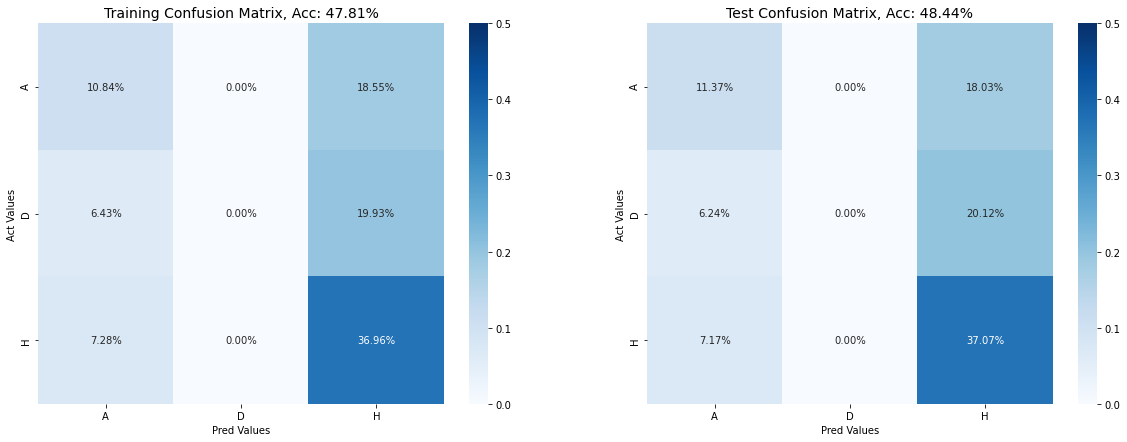

In [22]:
print_conf_mat(sm_model, y_test, x_test)